# An introduction to the simulator module

The pyGWB simulator module allows for the generation of an isotropic power-law stochastic GW background (GWB) for an arbitrary number of interferometers. In this tutorial, various ways to generate data will be covered, both directly through the simulator module, as well as through the network module (which calls the simulator module).

Note: for this tutorial, one should have a 'custom made' environment where pyGWB is installed and all dependencies are satisfied.

In [1]:
import numpy as np
import gwpy
import bilby
import sys
import matplotlib.pyplot as plt
import gwpy.timeseries
sys.path.insert(0,'..')
from pygwb.detector import Interferometer
from pygwb.network import Network
#from pygwb.parameters import Parameters
from pygwb.baseline import Baseline
from pygwb.simulator import Simulator
%matplotlib inline

## Simulating data with the simulator module directly

### Spectrum to inject

Among the parameters the simulator module expects is the spectrum to be injected in the form of a gwpy.frequencyseries. This spectrum is the power spectral density (PSD) of the GW signal Below, we define such a spectrum for some injection value of $\Omega_{\rm ref}$ at a reference frequency $f_{\rm ref}$. We will take a relatively large value for $\Omega_{\rm ref}$ such that the signal is large enough to rise above the noise curve. Note that this function can be used to generate any power-law spectrum.

In [51]:
frequencies_x = np.linspace(0, 1000, 10000)

alpha1 = 6
alpha2 = 2/3
fref = 10
omegaRef = 5.e-5

def IntensityGW(freqs, omegaRef, alpha1, fref, alpha2 = 2/3):
    ''' GW Intensity function from broken power law in OmegaGW '''
    '''
    
    PARAMETERS
    freqs: np.array
        frequency array
    fref: 
        reference frequency
    omegaRef: 
        Value of OmegaGW at reference frequency
    alpha1:
        first spectral index
    alpha2:
        second spectral index
        
    RETURN
    FrequencySeries
    
    '''
    from pygwb.constants import H0
    H_theor = (3 * H0.si.value ** 2) / (10 * np.pi ** 2)
    
    fknee = fref
    
    power = np.zeros_like(freqs)
    
    power[freqs<fknee] = H_theor * omegaRef * (freqs[freqs<fknee]) ** (alpha1 -3) * fref**(-alpha1)
    power[freqs>fknee] = H_theor * omegaRef * (freqs[freqs>fknee]) ** (alpha2 - 3) * fref**(-alpha2)
    power[freqs==fknee] = H_theor * omegaRef * (fknee) ** (alpha2 -3) * fref**(-alpha2)
    
    power[0] = power[1]
    
    return gwpy.frequencyseries.FrequencySeries(power, frequencies=freqs)

Intensity_GW_inject = IntensityGW(frequencies_x, omegaRef, alpha1, fref, alpha2)

Text(0, 0.5, 'PSD')

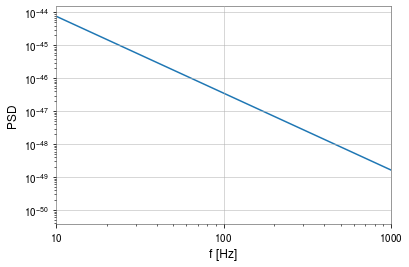

In [52]:
plt.loglog(Intensity_GW_inject.frequencies,Intensity_GW_inject.value)
plt.xlim(10,1000)
plt.xlabel('f [Hz]')
plt.ylabel('PSD')

### Parameters for the simulation

For this tutorial, we will simulate 5 segments (N_segs) of duration 64 (duration) with a sampling frequency of 1024 Hz. This is specified below.

In [53]:
duration = 64 # duration of each segment of data (s)
N_segs = 5  # number of data segments to generate
sampling_frequency = 1024 # Hz

Furthermore, the simulator module expects a list of bilby interferometers for which the data needs to be simulated. For this tutorial, we decide to use H1 and L1 as an example. However, note that the data can be simulated for an arbitrary amount of detectors. One would simply add more detectors to the *ifo_list* below.

In [54]:
ifo_H1 = bilby.gw.detector.get_empty_interferometer('H1')
ifo_L1 = bilby.gw.detector.get_empty_interferometer('L1')

ifo_list = [ifo_H1, ifo_L1]

for ifo in ifo_list:
    ifo.duration = duration
    ifo.sampling_frequency = sampling_frequency
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(ifo.frequency_array, np.nan_to_num(ifo.power_spectral_density_array, posinf=1.e-41))

We are now ready to simulate data. We consider two cases: one where only the signal is simulated and one where signal and noise are simulated. This can be controlled by the *no_noise* flag that can be passed to the simulator.

#### Signal only (no noise)

Note, since we did not pass the start time of the data, it will default to 0. We now initialize a simulator object and call *generate_data()* to generate the data.

In [55]:
simulator_signal = Simulator(ifo_list, Intensity_GW_inject, N_segs, duration = duration, sampling_frequency = sampling_frequency, no_noise=True)
data_signal = simulator_signal.generate_data()

2022-07-07 01:59:17.567 | INFO     | pygwb.simulator:generate_data:222 - Adding data to channel H1:SIM-STOCH_INJ
2022-07-07 01:59:17.594 | INFO     | pygwb.simulator:generate_data:222 - Adding data to channel L1:SIM-STOCH_INJ


For illustrative purposes, we plot the time domain strain and the psd of the simulated data below. As shown by the PSD, the simulated data nicely follows the desired spectrum (red line).

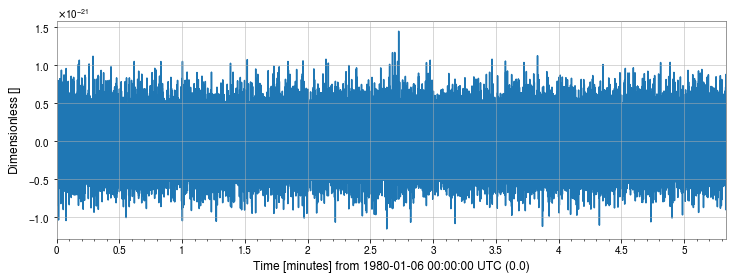

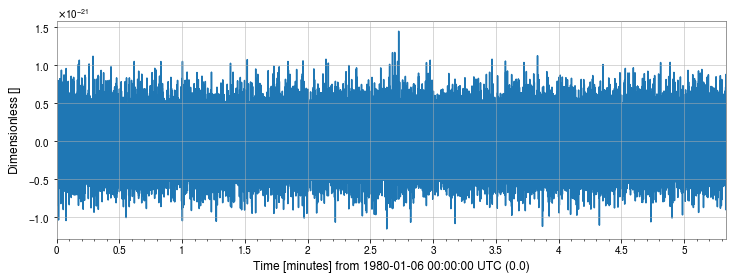

In [56]:
data_signal[0].plot()

Text(0, 0.5, 'PSD')

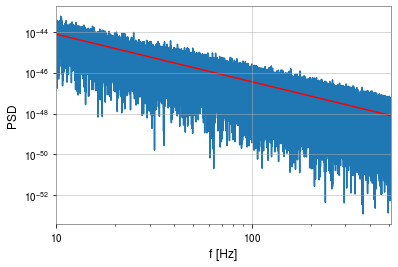

In [57]:
psd_signal = data_signal[0].psd().value
frequencies = data_signal[0].psd().frequencies.value

plt.loglog(frequencies,psd_signal)
plt.loglog(Intensity_GW_inject.frequencies,Intensity_GW_inject.value, color='r')
plt.xlim(10,512)
plt.xlabel('f [Hz]')
plt.ylabel('PSD')

As one can see, no noise was added on top of the signal. We now proceed by generating new data, with noise that follows the noise PSD specified in the interferometers passed to the simulator.

#### Signal and noise

In [58]:
simulator_signal_and_noise = Simulator(ifo_list, Intensity_GW_inject, N_segs, duration = duration, sampling_frequency = sampling_frequency, no_noise=False)
data_signal_and_noise = simulator_signal_and_noise.generate_data()

2022-07-07 01:59:30.092 | INFO     | pygwb.simulator:generate_data:222 - Adding data to channel H1:SIM-STOCH_INJ
2022-07-07 01:59:30.116 | INFO     | pygwb.simulator:generate_data:222 - Adding data to channel L1:SIM-STOCH_INJ


For illustrative purposes, we plot the time domain strain and the psd of the simulated data below.

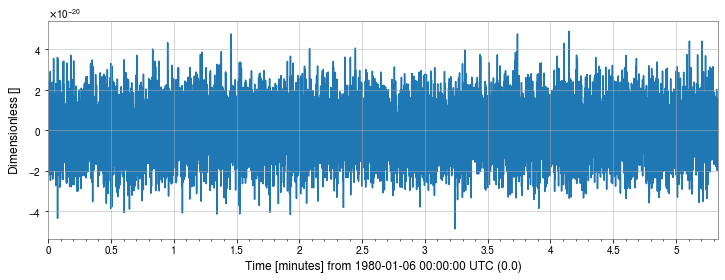

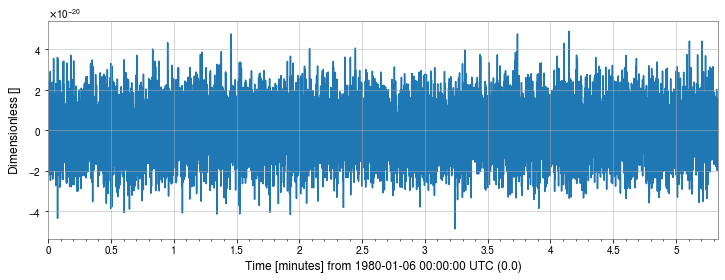

In [59]:
data_signal_and_noise[0].plot()

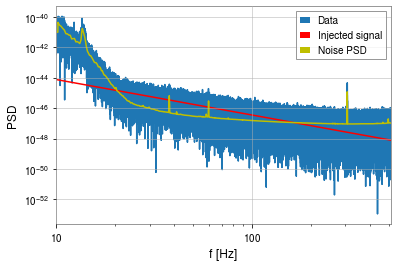

In [60]:
psd_signal_and_noise = data_signal_and_noise[0].psd().value
frequencies = data_signal_and_noise[0].psd().frequencies.value

plt.loglog(frequencies,psd_signal_and_noise, label="Data")
plt.loglog(Intensity_GW_inject.frequencies,Intensity_GW_inject.value, color='r', label="Injected signal")
plt.loglog(ifo_H1.power_spectral_density.frequency_array,ifo_H1.power_spectral_density.psd_array, color='y', label="Noise PSD")
plt.xlim(10,512)
plt.xlabel('f [Hz]')
plt.ylabel('PSD')
plt.legend()

From this, one sees the injection is visible, but only in regions where it rises above the noise PSD of the detector.

## Simulating data through the network module

For the second part of this tutorial, we illustrate how simulated data can be generated using the network module. In this case, the *set_interferometer_data_from_simulator* of the network module is called. Note that this is also the method that one calls to inject simulated data into real detector data. However, we will not consider that case in this tutorial and refer the interested reader to the other tutorial in this directory. We start by creating two empty interferometers and combine them into an network object.

In [61]:
ifo_H1 = bilby.gw.detector.get_empty_interferometer('H1')
ifo_L1 = bilby.gw.detector.get_empty_interferometer('L1')

ifo_list = [ifo_H1, ifo_L1]

for ifo in ifo_list:
    ifo.duration = duration
    ifo.sampling_frequency = sampling_frequency
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(ifo.frequency_array, np.nan_to_num(ifo.power_spectral_density_array, posinf=1.e-41))

In [62]:
HL_network = Network("HL_network",ifo_list)

Given a network object, one can call the *set_interferometer_data_from_simulator* to inject data in the interferometers of the network. This is illustrated below.

In [63]:
HL_network.set_interferometer_data_from_simulator(Intensity_GW_inject, N_segs, sampling_frequency, start_time=0.0, inject_into_data_flag=False)

2022-07-07 01:59:46.442 | INFO     | pygwb.simulator:generate_data:222 - Adding data to channel H1:SIM-STOCH_INJ
2022-07-07 01:59:46.466 | INFO     | pygwb.simulator:generate_data:222 - Adding data to channel L1:SIM-STOCH_INJ


In [64]:
data_H1=ifo_H1.strain_data.to_gwpy_timeseries()

We now plot both the time domain strain and the PSD of the data in the H1 interferometer. Similar plots can be made for L1.

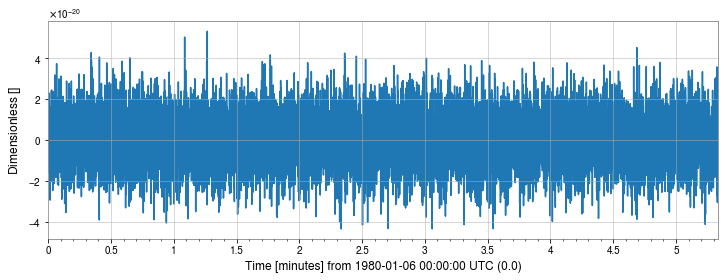

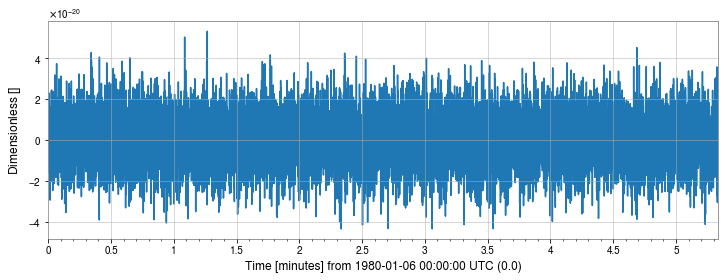

In [65]:
data_H1.plot()

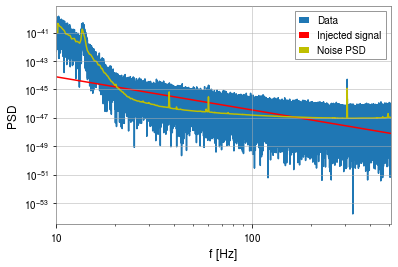

In [66]:
psd_signal_and_noise = data_H1.psd().value
frequencies = data_H1.psd().frequencies.value

plt.loglog(frequencies,psd_signal_and_noise, label="Data")
plt.loglog(Intensity_GW_inject.frequencies,Intensity_GW_inject.value, color='r', label="Injected signal")
plt.loglog(ifo_H1.power_spectral_density.frequency_array,ifo_H1.power_spectral_density.psd_array, color='y', label="Noise PSD")
plt.xlim(10,512)
plt.xlabel('f [Hz]')
plt.ylabel('PSD')
plt.legend()

This illustrates how one can use a network object to simulate data for the interferometers of the network. As mentioned earlier, the way to inject simulated data into real detector data is completely analogous to this case and is discussed in the other tutorial in this tutorial directory.

## Recovery test: averaged PSD

The above tests provide a first indication that the simulator works. We now proceed by performing 200 injections and looking at the average PSD of those 200 injections. We first define our signal to inject.

In [67]:
frequencies_x = np.linspace(0, 1000, 10000)

alpha1 = 6
alpha2 = 0
fref = 10
omegaRef = 5.e-5

def IntensityGW(freqs, omegaRef, alpha1, fref, alpha2 = 2/3):
    ''' GW Intensity function from broken power law in OmegaGW '''
    '''
    
    PARAMETERS
    freqs: np.array
        frequency array
    fref: 
        reference frequency
    omegaRef: 
        Value of OmegaGW at reference frequency
    alpha1:
        first spectral index
    alpha2:
        second spectral index
        
    RETURN
    FrequencySeries
    
    '''
    from pygwb.constants import H0
    H_theor = (3 * H0.si.value ** 2) / (10 * np.pi ** 2)
    
    fknee = fref
    
    power = np.zeros_like(freqs)
    
    power[freqs<fknee] = H_theor * omegaRef * (freqs[freqs<fknee]) ** (alpha1 -3) * fref**(-alpha1)
    power[freqs>fknee] = H_theor * omegaRef * (freqs[freqs>fknee]) ** (alpha2 - 3) * fref**(-alpha2)
    power[freqs==fknee] = H_theor * omegaRef * (fknee) ** (alpha2 -3) * fref**(-alpha2)
    
    #power[freqs<10.]= omegaRef * (10. / fref) ** alpha1
    power[0] = power[1]
    
    return gwpy.frequencyseries.FrequencySeries(power, frequencies=freqs)

Intensity_GW_inject = IntensityGW(frequencies_x, omegaRef = omegaRef, alpha1 = alpha1, fref = fref)

The parameters used for the injection are the following.

In [11]:
duration = 64
# duration of each segment of data (s)
N_segs = 2
# number of data segments to generate
sampling_frequency = 1024
# Hz

We can now set up the two interferometers used in this simulation study (H and L)

In [4]:
ifo_H1 = bilby.gw.detector.get_empty_interferometer('H1')
ifo_L1 = bilby.gw.detector.get_empty_interferometer('L1')

ifo_list = [ifo_H1, ifo_L1]

for ifo in ifo_list:
    ifo.duration = duration
    ifo.sampling_frequency = sampling_frequency
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(ifo.frequency_array, np.nan_to_num(ifo.power_spectral_density_array, posinf=1.e-41))

The PSD will be fit to a straight line (on a log-log plot) to recover the injected Omega value. This function is defined in the cell below.

In [5]:
def func(x,a,b):
    return 10**(a*np.log10(x)+b)

### Signal and noise

We first simulate the data 200 times with signal and noise. We then proceed by taking the PSD of the data and look at the average PSD over the 200 realizations.

In [12]:
Ntests=200

psd_array_H1=np.zeros(Ntests, dtype=gwpy.frequencyseries.FrequencySeries)

for ii in range(Ntests):
    simulator_1 = Simulator(ifo_list, Intensity_GW_inject, N_segments = N_segs, duration = duration, sampling_frequency = sampling_frequency)
    dataset = simulator_1.generate_data()
    data_H1, data_L1 = dataset
    
    psd_array_H1[ii]=data_H1.psd()

2022-05-23 00:10:54.539 | INFO     | pygwb.simulator:generate_data:214 - Adding data to channel H1:SIM-STOCH_INJ
2022-05-23 00:10:54.551 | INFO     | pygwb.simulator:generate_data:214 - Adding data to channel L1:SIM-STOCH_INJ
2022-05-23 00:10:57.238 | INFO     | pygwb.simulator:generate_data:214 - Adding data to channel H1:SIM-STOCH_INJ
2022-05-23 00:10:57.251 | INFO     | pygwb.simulator:generate_data:214 - Adding data to channel L1:SIM-STOCH_INJ
2022-05-23 00:10:59.977 | INFO     | pygwb.simulator:generate_data:214 - Adding data to channel H1:SIM-STOCH_INJ
2022-05-23 00:10:59.988 | INFO     | pygwb.simulator:generate_data:214 - Adding data to channel L1:SIM-STOCH_INJ
2022-05-23 00:11:02.689 | INFO     | pygwb.simulator:generate_data:214 - Adding data to channel H1:SIM-STOCH_INJ
2022-05-23 00:11:02.704 | INFO     | pygwb.simulator:generate_data:214 - Adding data to channel L1:SIM-STOCH_INJ
2022-05-23 00:11:05.427 | INFO     | pygwb.simulator:generate_data:214 - Adding data to channel 

In [13]:
freqs_1=psd_array_H1[0].frequencies.value
mask_1=(freqs_1>25)&(freqs_1<100)

psd_average=np.zeros(psd_array_H1[0].frequencies.value.shape)
# psd_array_L1=np.zeros(Ntests)

# spectral_array=np.zeros(Ntests)
# intercept_array=np.zeros(Ntests)
# mask1=(frequencies>20)&(frequencies<200)

for ii in range(Ntests):
    psd_average+=1/Ntests*psd_array_H1[ii].value

popt,pcov=optimize.curve_fit(func,freqs_1[mask_1],psd_average[mask_1])

spectral_avg=popt[0]
intercept_avg=popt[1]

The numbers below report the values from the fit and look at the difference between injected and fitted parameters (spectral index and Omega). The somewhat large difference in Omega recovery is attributed to the noise. We therefore consider the signal only case below.

In [14]:
from pygwb.constants import H0
H_theor = (3 * H0 ** 2) / (10 * np.pi ** 2)

omegaRef_avg=func(fref,spectral_avg,intercept_avg)/H_theor*fref**3

print(f"fit spectral index from PSD average: {spectral_avg}")
print(f"fit Omega(fref) from PSD average: {omegaRef_avg}")
print(f"% difference between spectral indices: {100*np.abs((spectral_avg-(2/3-3))/(2/3-3))}")
print(f"% difference between Omega(fref): {100*np.abs(omegaRef-omegaRef_avg)/omegaRef}")

fit spectral index from PSD average: -2.311242553049733
fit Omega(fref) from PSD average: 5.290843104709632e-05
% difference between spectral indices: 0.9467477264400146
% difference between Omega(fref): 5.816862094192637


Text(0, 0.5, 'PSD')

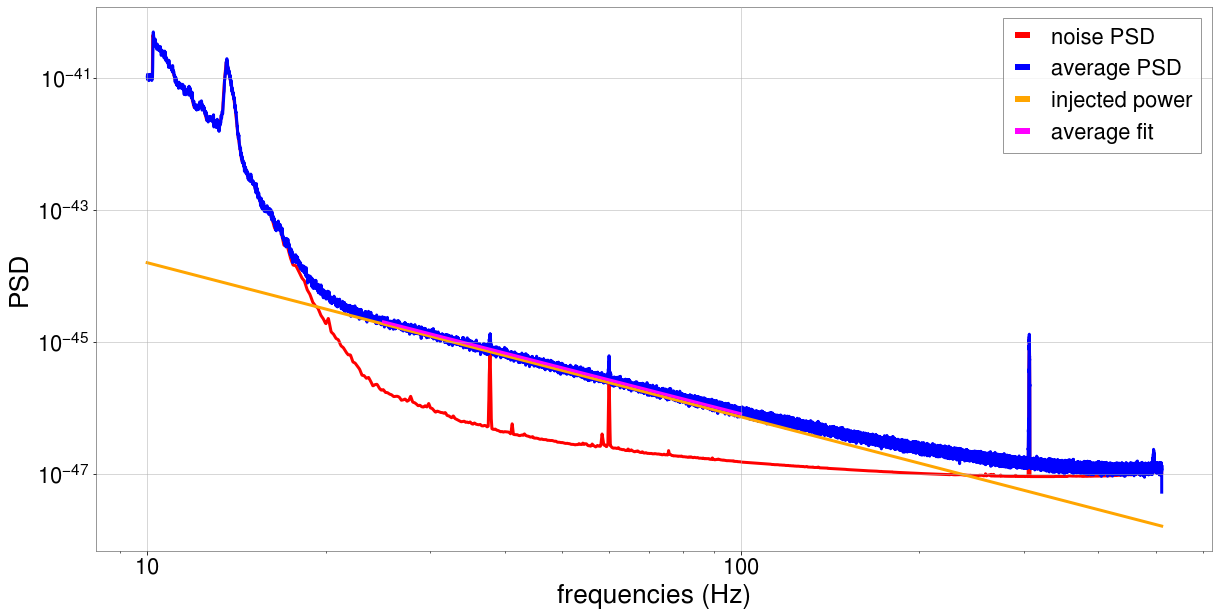

In [15]:
mask_2 = (freqs_1>10)&(freqs_1<freqs_1[-1])
mask_3 = (Intensity_GW_inject.frequencies.value>10)&(Intensity_GW_inject.frequencies.value<freqs_1[-1]) 
mask_4 = (ifo_H1.power_spectral_density.frequency_array>10)&(ifo_H1.power_spectral_density.frequency_array<freqs_1[-1]) 

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'font.size': 22})
ax, fig = plt.subplots(figsize = (20,10))
plt.loglog(ifo_H1.power_spectral_density.frequency_array[mask_4], ifo_H1.power_spectral_density.psd_array[mask_4], linewidth = 3, color = 'red', label = 'noise PSD')
plt.loglog(freqs_1[mask_2], psd_average[mask_2], linewidth = 3, color = 'blue', label = 'average PSD')
plt.loglog(Intensity_GW_inject.frequencies.value[mask_3], Intensity_GW_inject.value[mask_3], linewidth = 3, label = 'injected power',color='orange')
plt.loglog(freqs_1[mask_1], func(freqs_1[mask_1],spectral_avg,intercept_avg), linewidth = 3, color = 'magenta', label = 'average fit')
plt.legend()
plt.xlabel('frequencies (Hz)')
plt.ylabel('PSD')

### Signal only

We repeat the above test, but now for signal only in the data.

In [16]:
Ntests=200

psd_array_H1=np.zeros(Ntests, dtype=gwpy.frequencyseries.FrequencySeries)
# psd_array_L1=np.zeros(Ntests)

# spectral_array=np.zeros(Ntests)
# intercept_array=np.zeros(Ntests)
# mask1=(frequencies>20)&(frequencies<200)

for ii in range(Ntests):
    simulator_1 = Simulator(ifo_list, Intensity_GW_inject, N_segments = N_segs, duration = duration, sampling_frequency = sampling_frequency, no_noise=True)
    dataset = simulator_1.generate_data()
    data_H1, data_L1 = dataset
    
    psd_array_H1[ii]=data_H1.psd()

2022-05-23 00:29:41.276 | INFO     | pygwb.simulator:generate_data:214 - Adding data to channel H1:SIM-STOCH_INJ
2022-05-23 00:29:41.289 | INFO     | pygwb.simulator:generate_data:214 - Adding data to channel L1:SIM-STOCH_INJ
2022-05-23 00:29:42.684 | INFO     | pygwb.simulator:generate_data:214 - Adding data to channel H1:SIM-STOCH_INJ
2022-05-23 00:29:42.697 | INFO     | pygwb.simulator:generate_data:214 - Adding data to channel L1:SIM-STOCH_INJ
2022-05-23 00:29:44.078 | INFO     | pygwb.simulator:generate_data:214 - Adding data to channel H1:SIM-STOCH_INJ
2022-05-23 00:29:44.090 | INFO     | pygwb.simulator:generate_data:214 - Adding data to channel L1:SIM-STOCH_INJ
2022-05-23 00:29:45.468 | INFO     | pygwb.simulator:generate_data:214 - Adding data to channel H1:SIM-STOCH_INJ
2022-05-23 00:29:45.480 | INFO     | pygwb.simulator:generate_data:214 - Adding data to channel L1:SIM-STOCH_INJ
2022-05-23 00:29:46.860 | INFO     | pygwb.simulator:generate_data:214 - Adding data to channel 

In [24]:
freqs_1=psd_array_H1[0].frequencies.value
mask_1=(freqs_1>10)&(freqs_1<512)

psd_average=np.zeros(psd_array_H1[0].frequencies.value.shape)
# psd_array_L1=np.zeros(Ntests)

# spectral_array=np.zeros(Ntests)
# intercept_array=np.zeros(Ntests)
# mask1=(frequencies>20)&(frequencies<200)

for ii in range(Ntests):
    psd_average+=1/Ntests*psd_array_H1[ii].value

popt,pcov=optimize.curve_fit(func,freqs_1[mask_1],psd_average[mask_1])

spectral_avg=popt[0]
intercept_avg=popt[1]

In [25]:
from pygwb.constants import H0
H_theor = (3 * H0 ** 2) / (10 * np.pi ** 2)

omegaRef_avg=func(fref,spectral_avg,intercept_avg)/H_theor*fref**3

print(f"fit spectral index from PSD average: {spectral_avg}")
print(f"fit Omega(fref) from PSD average: {omegaRef_avg}")
print(f"% difference between spectral indices: {100*np.abs((spectral_avg-(2/3-3))/(2/3-3))}")
print(f"% difference between Omega(fref): {100*np.abs(omegaRef-omegaRef_avg)/omegaRef}")

fit spectral index from PSD average: -2.3422843687995503
fit Omega(fref) from PSD average: 5.030512956769551e-05
% difference between spectral indices: 0.383615805695005
% difference between Omega(fref): 0.6102591353910112


As expected, the difference between injected and recovered is less when only the signal is injected without the noise.

Text(0, 0.5, 'PSD')

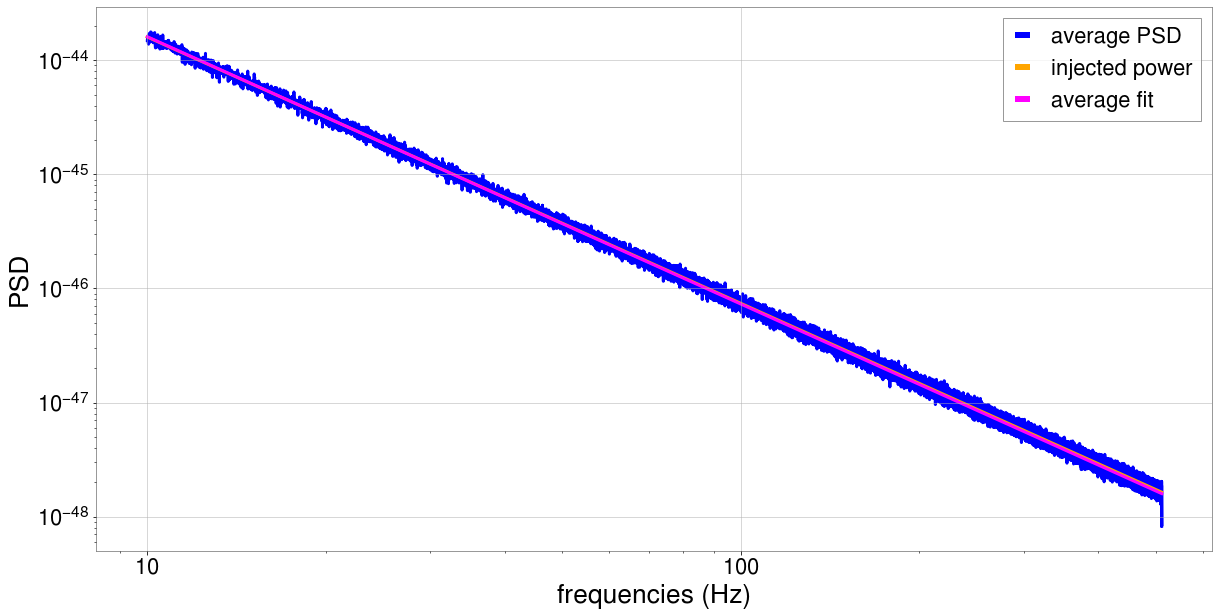

In [26]:
mask_2 = (freqs_1>10)&(freqs_1<freqs_1[-1])
mask_3 = (Intensity_GW_inject.frequencies.value>10)&(Intensity_GW_inject.frequencies.value<freqs_1[-1]) 
mask_4 = (ifo_H1.power_spectral_density.frequency_array>10)&(ifo_H1.power_spectral_density.frequency_array<freqs_1[-1]) 

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'font.size': 22})
ax, fig = plt.subplots(figsize = (20,10))
plt.loglog(freqs_1[mask_2], psd_average[mask_2], linewidth = 3, color = 'blue', label = 'average PSD')
plt.loglog(Intensity_GW_inject.frequencies.value[mask_3], Intensity_GW_inject.value[mask_3], linewidth = 3, label = 'injected power',color='orange')
plt.loglog(freqs_1[mask_1], func(freqs_1[mask_1],spectral_avg,intercept_avg), linewidth = 3, color = 'magenta', label = 'average fit')
plt.legend()
plt.xlabel('frequencies (Hz)')
plt.ylabel('PSD')